In [20]:
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import seaborn as sns

In [2]:
apparel_list = ['T-Shirt','Shirt', 'Dress', 'Pants', 'Shorts','Skirt']

In [3]:
import pickle

with open('apparel_list.pkl', 'wb') as f:
    pickle.dump(apparel_list, f)

In [4]:
IMG_SIZE = 224

def process_image(image_path,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
    image = tf.io.read_file(image_path) # Read image file
    image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
    image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
    image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    return image 

In [5]:
def get_image_label(image_path,label):
    """
    Take an image file path name and the associated label,
    process the image and return a tuple of (image,label)
    """
    image = process_image(image_path)
    return image,label

In [6]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X) and lebel (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is valid dataset, we don't have to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [7]:
import matplotlib.pyplot as plt

def show_25_images(images,labels,predicted):
    """
    Display a plot of 25 images and their labels from a batch.
    """
    plt.figure(figsize=(15,10))
    for i in range(25):
        if apparel_list[labels[i].argmax()] == apparel_list[predicted[i].argmax()]:
            color = 'blue'
        else:
            color = 'red'
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(apparel_list[labels[i].argmax()],color=color)
        plt.axis("off")

In [8]:
model = tf.keras.models.load_model("models/apparel-classification.h5",custom_objects={'KerasLayer':hub.KerasLayer})

2022-04-30 19:45:26.700761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating testing data batches...


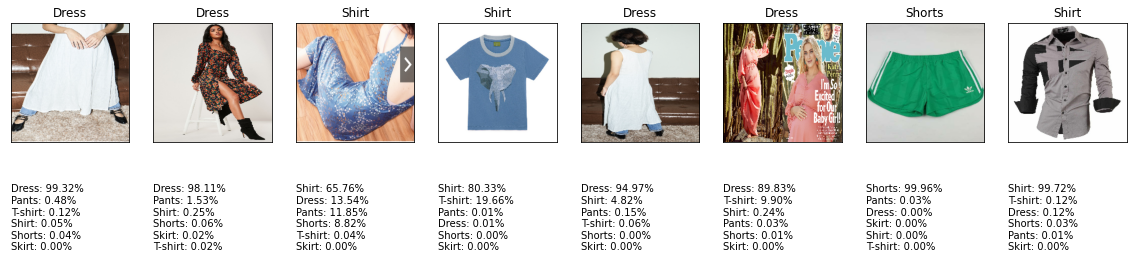

In [9]:
# Test the real images
predicted_list = []
custom_path= "test/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if fname !=".DS_Store"]
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_preds = model.predict(custom_data)
for preds in custom_preds:
    temp_list = []
    for i,pred in enumerate(preds,0): 
        temp_list.append([pred,apparel_list[i]])
    predicted_list.append(temp_list)
custom_preds_label = [apparel_list[np.argmax(cp)] for cp in custom_preds]
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)
string_list = []
for preds in predicted_list:
    string = ""
    for pred in sorted(preds,reverse=True):
        string+= pred[1].capitalize()+f": {pred[0]*100:.2f}%\n"
    string_list.append(string)
plt.figure(figsize=(20, 15))
for i, image in enumerate(custom_images):
    plt.subplot(1, len(custom_preds_label), i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_label[i])
    plt.text(0,450,s=string_list[i])
    plt.imshow(image)

Creating testing data batches...


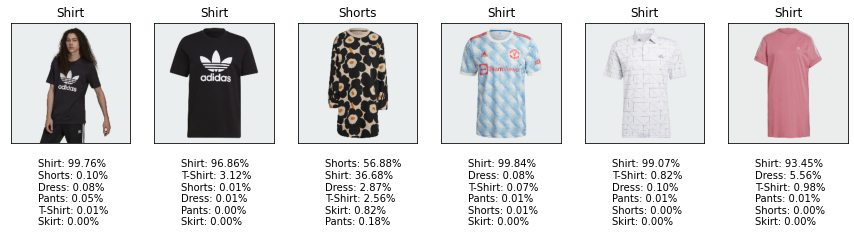

In [10]:
# Test the real images
predicted_list = []
custom_path= "images_test/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if fname !=".DS_Store"]
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_preds = model.predict(custom_data)
for preds in custom_preds:
    temp_list = []
    for i,pred in enumerate(preds,0): 
        temp_list.append([pred,apparel_list[i]])
    predicted_list.append(temp_list)
custom_preds_label = [apparel_list[np.argmax(cp)] for cp in custom_preds]
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)
string_list = []
for preds in predicted_list:
    string = ""
    for pred in sorted(preds,reverse=True):
        string+= pred[1]+f": {pred[0]*100:.2f}%\n"
    string_list.append(string)
plt.figure(figsize=(15, 15))
for i, image in enumerate(custom_images):
    plt.subplot(1, len(custom_preds_label), i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_label[i])
    plt.text(50,400,s=string_list[i])
    plt.imshow(image)

In [11]:
data = pd.read_csv("data/image_labels.csv")
data

,image,label
0,data/apparels/Skirt/f4b934fc-e326-4f72-b535-53...,Skirt
1,data/apparels/Skirt/fdbcfdcd-5deb-4a20-9aef-b7...,Skirt
2,data/apparels/Skirt/ecfd00ef-2fe1-4778-a2a8-e9...,Skirt
3,data/apparels/Skirt/2ac96388-4353-44b6-a174-de...,Skirt
4,data/apparels/Skirt/bd289469-607c-45df-bad3-ed...,Skirt
...,...,...
11682,data/apparels/Shirt/7be93c0fe39fd61ea0c5217ea9...,Shirt
11683,data/apparels/Shirt/45279e1f-82af-4fe3-b0ad-2b...,Shirt
11684,data/apparels/Shirt/aaeccde537821c284988d61777...,Shirt
11685,data/apparels/Shirt/ae9cec7a-dd1d-49bc-adae-64...,Shirt


In [12]:
apparel_list = ['T-Shirt','Shirt', 'Dress', 'Pants', 'Shorts','Skirt']
apparel_dict = {'T-Shirt':0,'Shirt':1, 'Dress':2, 'Pants':3, 'Shorts':4,'Skirt':5}

In [13]:
data_label = data["label"].to_numpy()
boolean_data_label = [label == np.array(apparel_list) for label in data_label]

In [14]:
X = list(data["image"].values)
y = boolean_data_label

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [16]:
val_data = create_data_batches(X=X_test,y=y_test,valid_data=True)

Creating validation data batches...


In [18]:
test_predicted = model.predict(val_data)
list_predicted = [l.argmax() for l in np.round(test_predicted)]
list_y_test = [l.argmax() for l in y_test]

In [24]:
from sklearn.metrics import accuracy_score

print(f"The accuracy: {accuracy_score(list_predicted,list_y_test)*100:.2f}")

The accuracy: 90.89


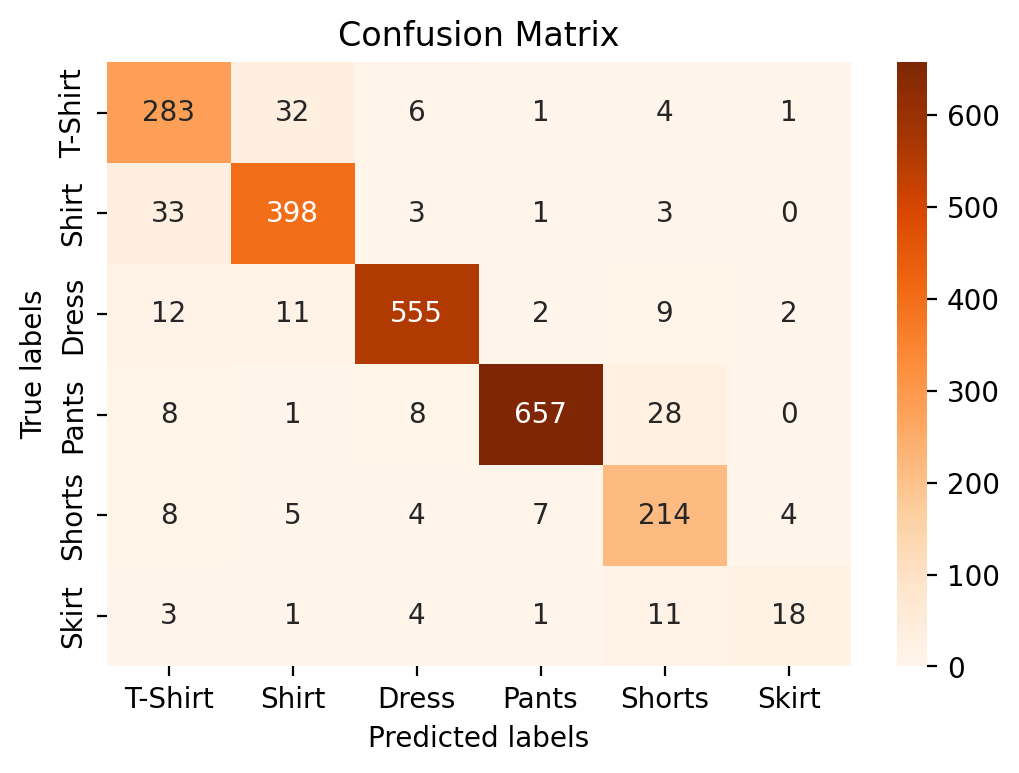

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_y_test,list_predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='.0f',cmap='Oranges'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(apparel_list)); ax.yaxis.set_ticklabels(list(apparel_list));
plt.gcf().set_dpi(200)